In [1]:
from __future__ import print_function
import PIL
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})
import csv

from mpl_toolkits import mplot3d
from matplotlib.pyplot import text
from IPython.display import display, Math, Latex, Markdown
import os
from tqdm.notebook import tqdm
import random
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstatsπ
from astroML.linear_model import LinearRegression
from astroML.classification import GMMBayes
from astroML.utils import completeness_contamination


from scipy import stats, interpolate
from astropy.visualization import hist

from sklearn import datasets, preprocessing
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

/home/olga/anaconda3/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


# Classification: galaxy or quasar?

### Import data

In [2]:
import requests

if not os.path.exists("./galaxyquasar.csv"):
    
    # Download file
    r = requests.get('https://raw.githubusercontent.com/dgerosa/astrostatistics_bicocca_2023/main/solutions/galaxyquasar.csv')

else:
        data = pd.read_csv("galaxyquasar.csv", delimiter= ',')
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [3]:
u_g = np.array(data['u'] - data['g'])
g_r = np.array(data['g'] - data['r'])
r_i = np.array(data['r'] - data['i'])
i_z = np.array(data['i'] - data['z'])
z_red = np.array(data['z1'])
X = np.column_stack((u_g, g_r, r_i, i_z, z_red))

In [4]:
class_ = np.array(data['class'])
class_

target = np.where(class_=='QSO',1,0)
target[:5]

array([1, 0, 0, 0, 1])

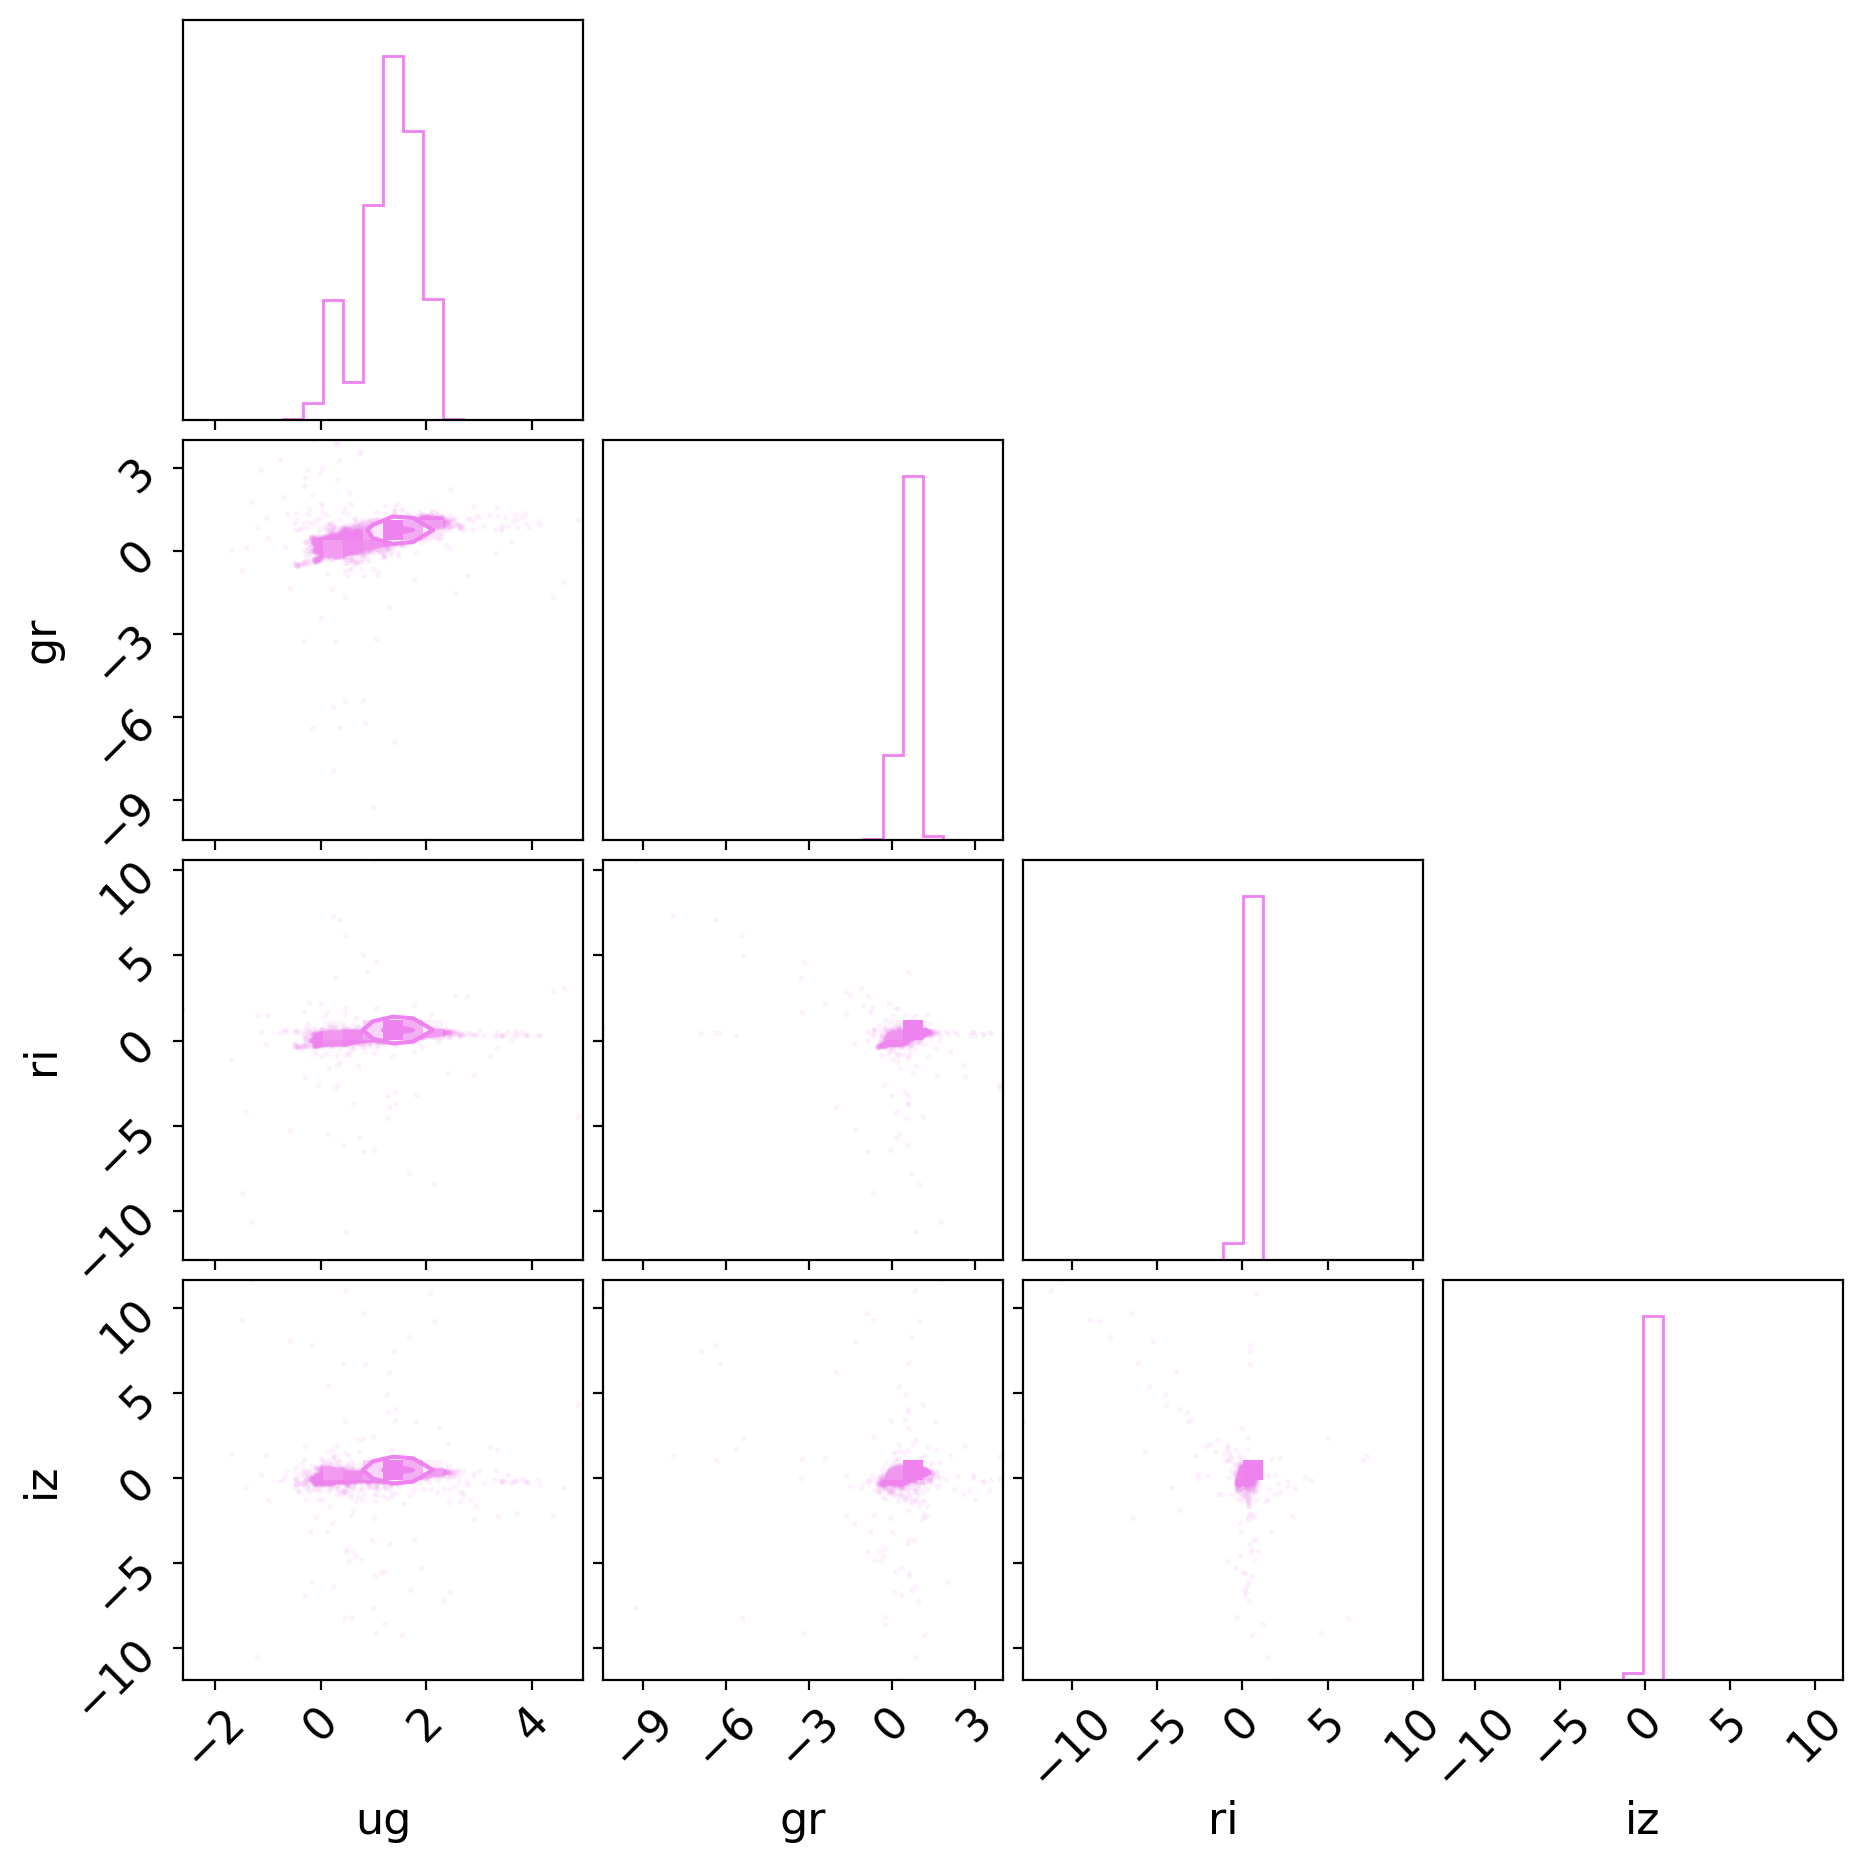

In [5]:
import corner
corner.corner(np.array([u_g,g_r,r_i,i_z]).T, labels=['ug', 'gr', 'ri', 'iz'],color='violet');

/tmp/ipykernel_8999/2415716613.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(u_g,g_r, s=20, c=target, cmap=plt.cm.get_cmap('spring', 2),zorder=1)


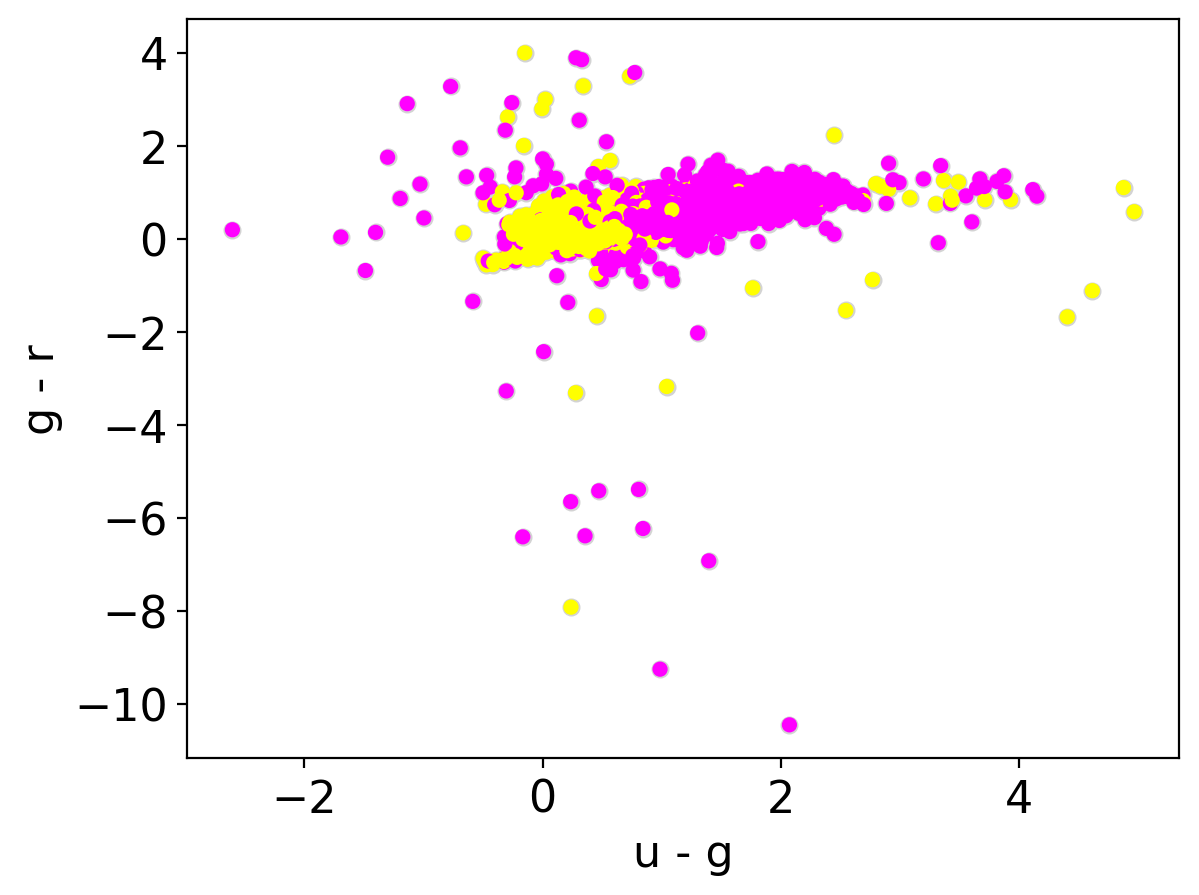

In [6]:
%matplotlib inline

plt.scatter(u_g,g_r, s=20, c=target, cmap=plt.cm.get_cmap('spring', 2),zorder=1)
plt.scatter(u_g,g_r, s=30, c='lightgray', zorder=0)
plt.xlabel("u - g")
plt.ylabel("g - r")
plt.show()

/tmp/ipykernel_8999/2853458032.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sctt1 = ax.scatter3D(u_g, g_r, z_red, c = target, cmap=plt.cm.get_cmap('spring', 2))#, edgecolor='gray')


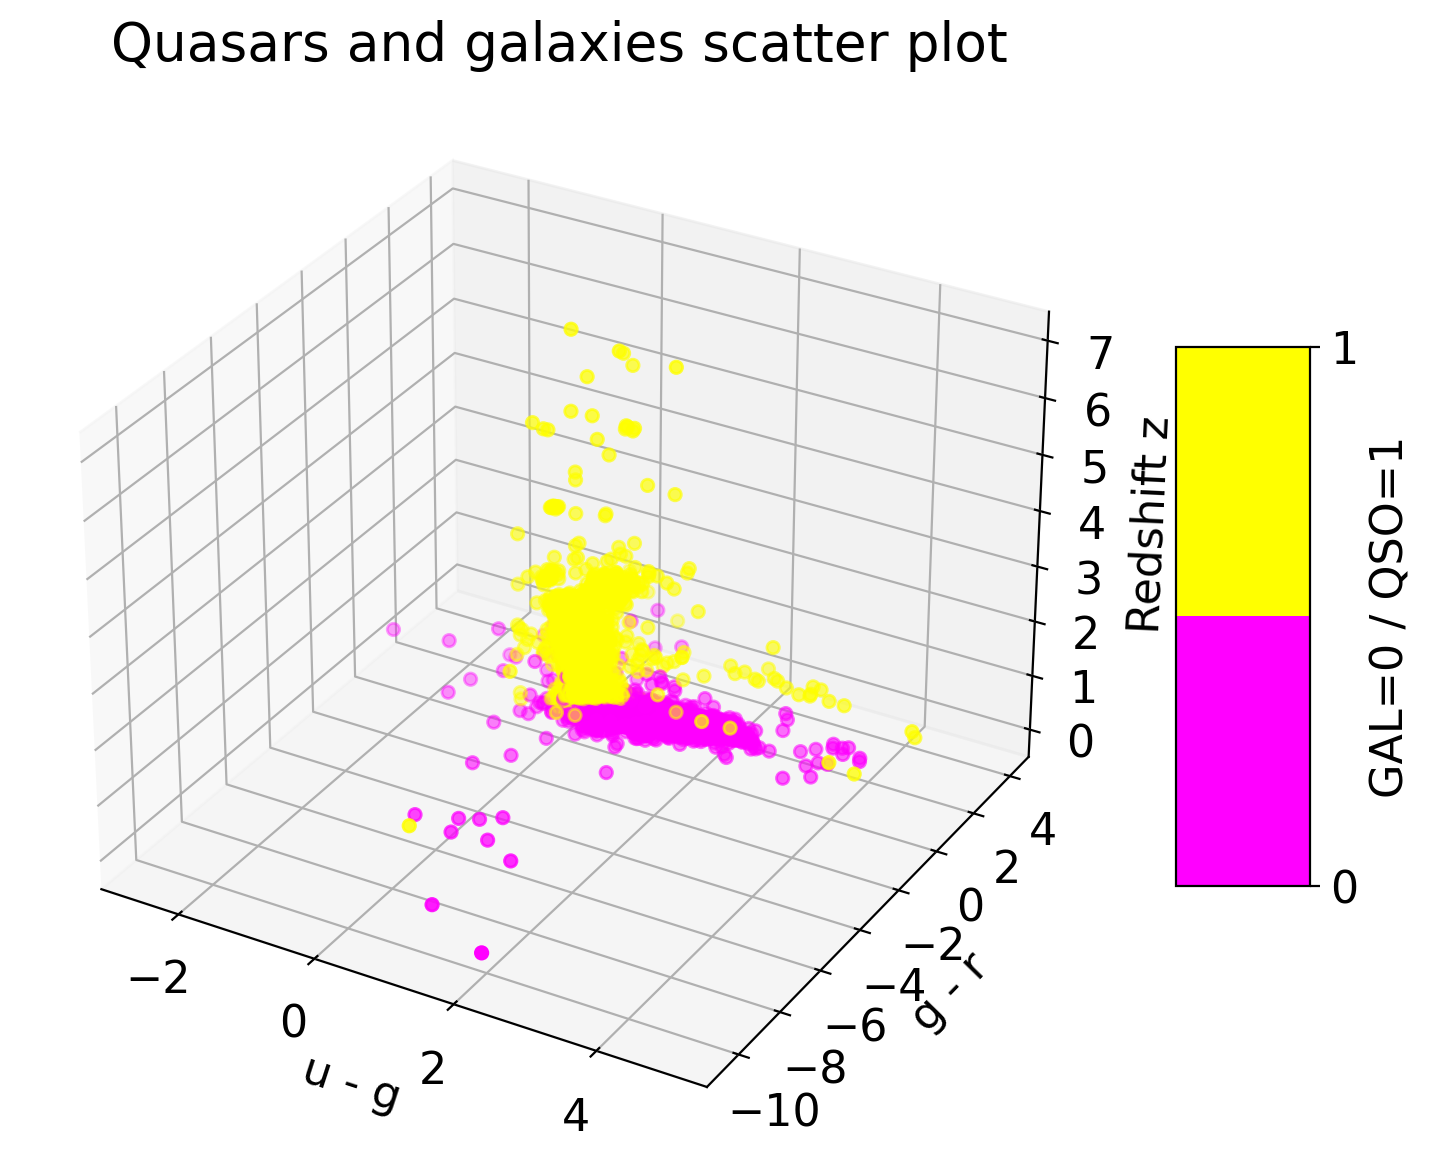

In [7]:
#%matplotlib notebook

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.set_xlabel("u - g")
ax.set_ylabel("g - r")
ax.set_zlabel("Redshift z")
ax.set_zticks(ticks=np.arange(0,10))

 
# Creating plot
sctt1 = ax.scatter3D(u_g, g_r, z_red, c = target, cmap=plt.cm.get_cmap('spring', 2))#, edgecolor='gray')
plt.title("Quasars and galaxies scatter plot")
fig.colorbar(sctt1, ax = ax, shrink = 0.5, aspect = 4, label="GAL=0 / QSO=1", ticks=range(10))
 
# show plot
plt.show()

### Split data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.20, random_state=42)
print(X_train.shape, X_train.shape[0]/X.shape[0])

(40000, 5) 0.8


In [9]:
X_train[:,0:]

array([[ 0.05419   ,  0.16652   , -0.02821   , -0.17067   ,  1.197966  ],
       [ 1.13378   ,  0.64846   ,  0.42559   ,  0.25712   ,  0.12058   ],
       [ 0.05648   ,  0.28302   ,  0.03651   , -0.00645   ,  1.273099  ],
       ...,
       [ 1.24964   ,  0.46567   ,  0.25843   ,  0.18929   ,  0.04041075],
       [ 1.43284   ,  0.64599   ,  0.28546   ,  0.15602   ,  0.        ],
       [ 0.12009   ,  0.11677   ,  0.34194   ,  0.06675   ,  1.850047  ]])

In [10]:
X_train[:,4]

array([1.197966  , 0.12058   , 1.273099  , ..., 0.04041075, 0.        ,
       1.850047  ])

### Classification with GMM Bayes

###### Let's try the classification with all 5 components (4 colors + redshift) at same time

In [11]:
gmmb = GMMBayes(2) # 2 clusters per class
gmmb.fit(X_train,y_train)

y_pred_train = gmmb.predict(X_train)
y_pred_test = gmmb.predict(X_test)
print(y_pred_train.shape, y_pred_test.shape)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9444438af0>
Traceback (most recent call last):
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

(40000,) (10000,)


/tmp/ipykernel_8999/728668327.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_train[:,0],X_train[:,1], s=10, c=y_pred_train, cmap=plt.cm.get_cmap('spring', 2), zorder=1)


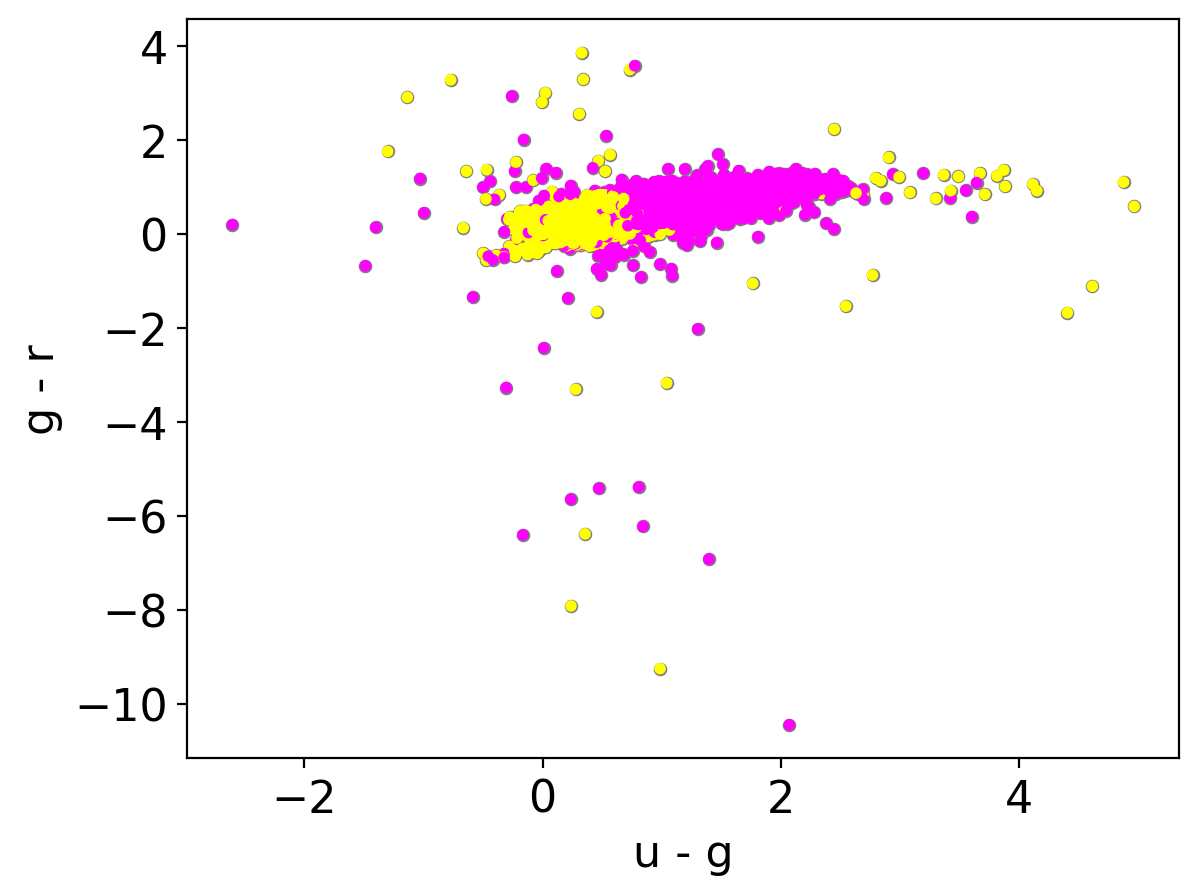

In [12]:
%matplotlib inline

#plot contours
"""
xlim = (-3, 6)
ylim = (-11, 5)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),np.linspace(ylim[0], ylim[1], 81))
Z = gmmb.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)
"""

plt.scatter(X_train[:,0],X_train[:,1], s=10, c=y_pred_train, cmap=plt.cm.get_cmap('spring', 2), zorder=1)
plt.scatter(X_train[:,0],X_train[:,1], s=15, c='gray', zorder=0)
plt.xlabel("u - g")
plt.ylabel("g - r")
plt.show()

/tmp/ipykernel_8999/490875917.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sctt2 = ax.scatter3D(X_train[:,0], X_train[:,1], y_pred_train, s=10, c = y_train, cmap=plt.cm.get_cmap('spring', 2))#, edgecolor='gray', zorder=1)


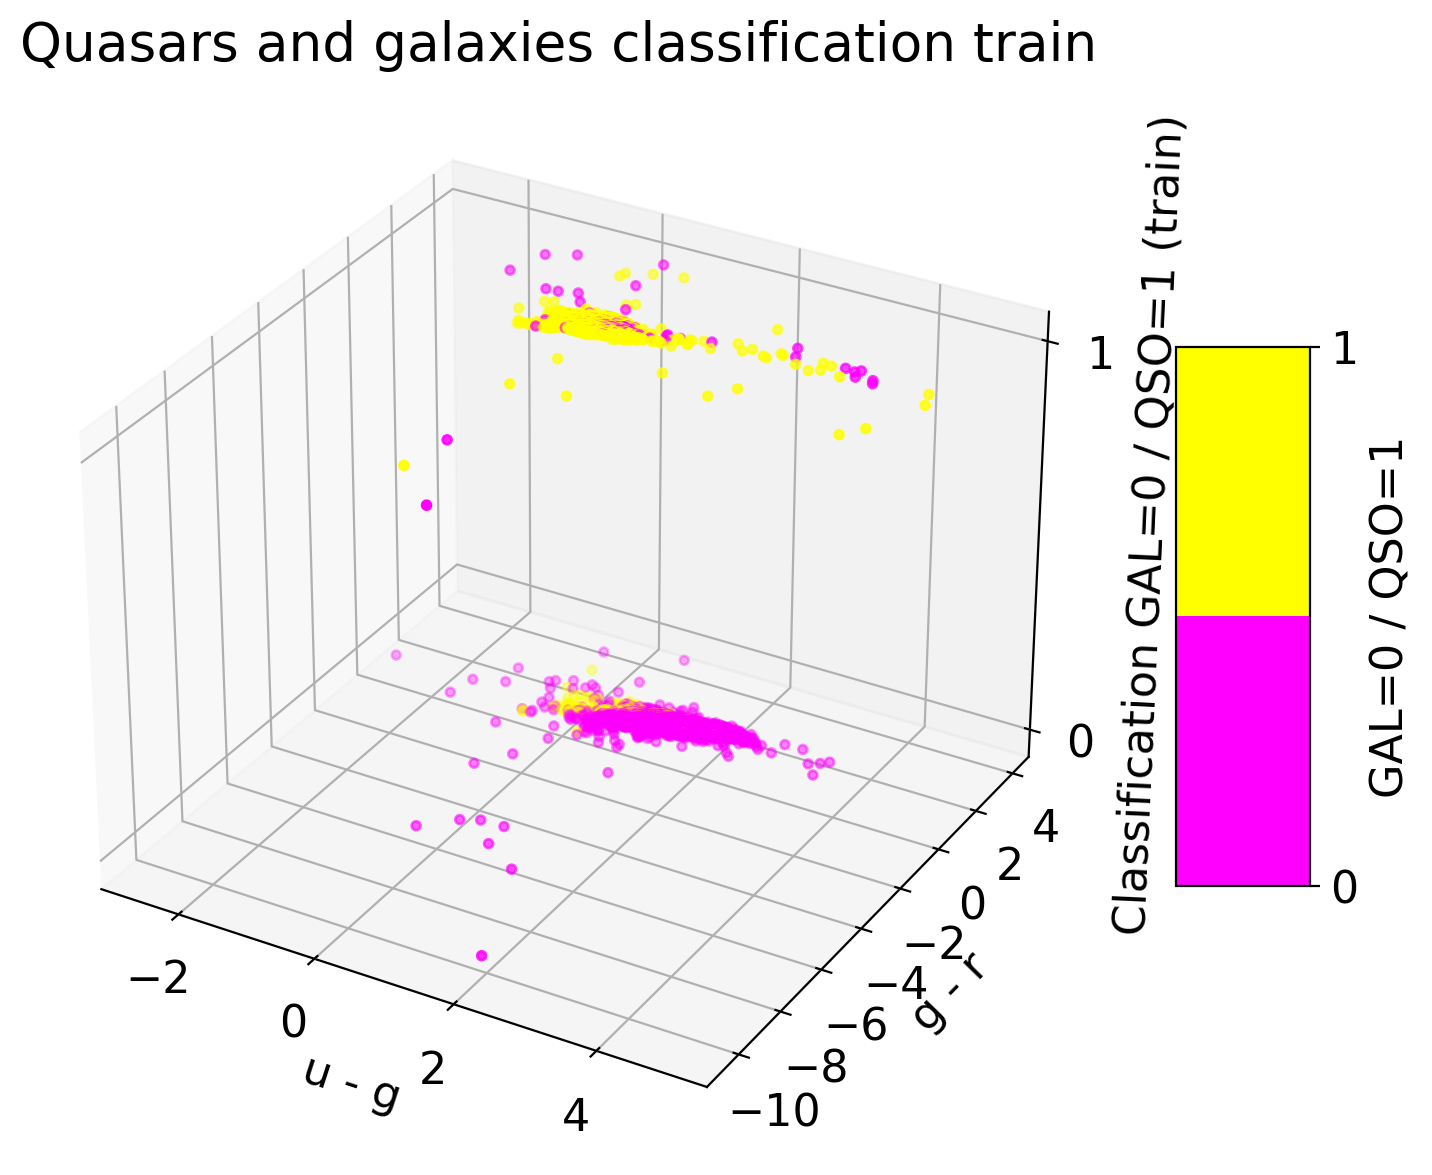

/tmp/ipykernel_8999/490875917.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sctt2 = ax.scatter3D(X_test[:,0], X_test[:,1], y_pred_test, s=10, c = y_test, cmap=plt.cm.get_cmap('spring', 2))#, edgecolor='gray', zorder=1)


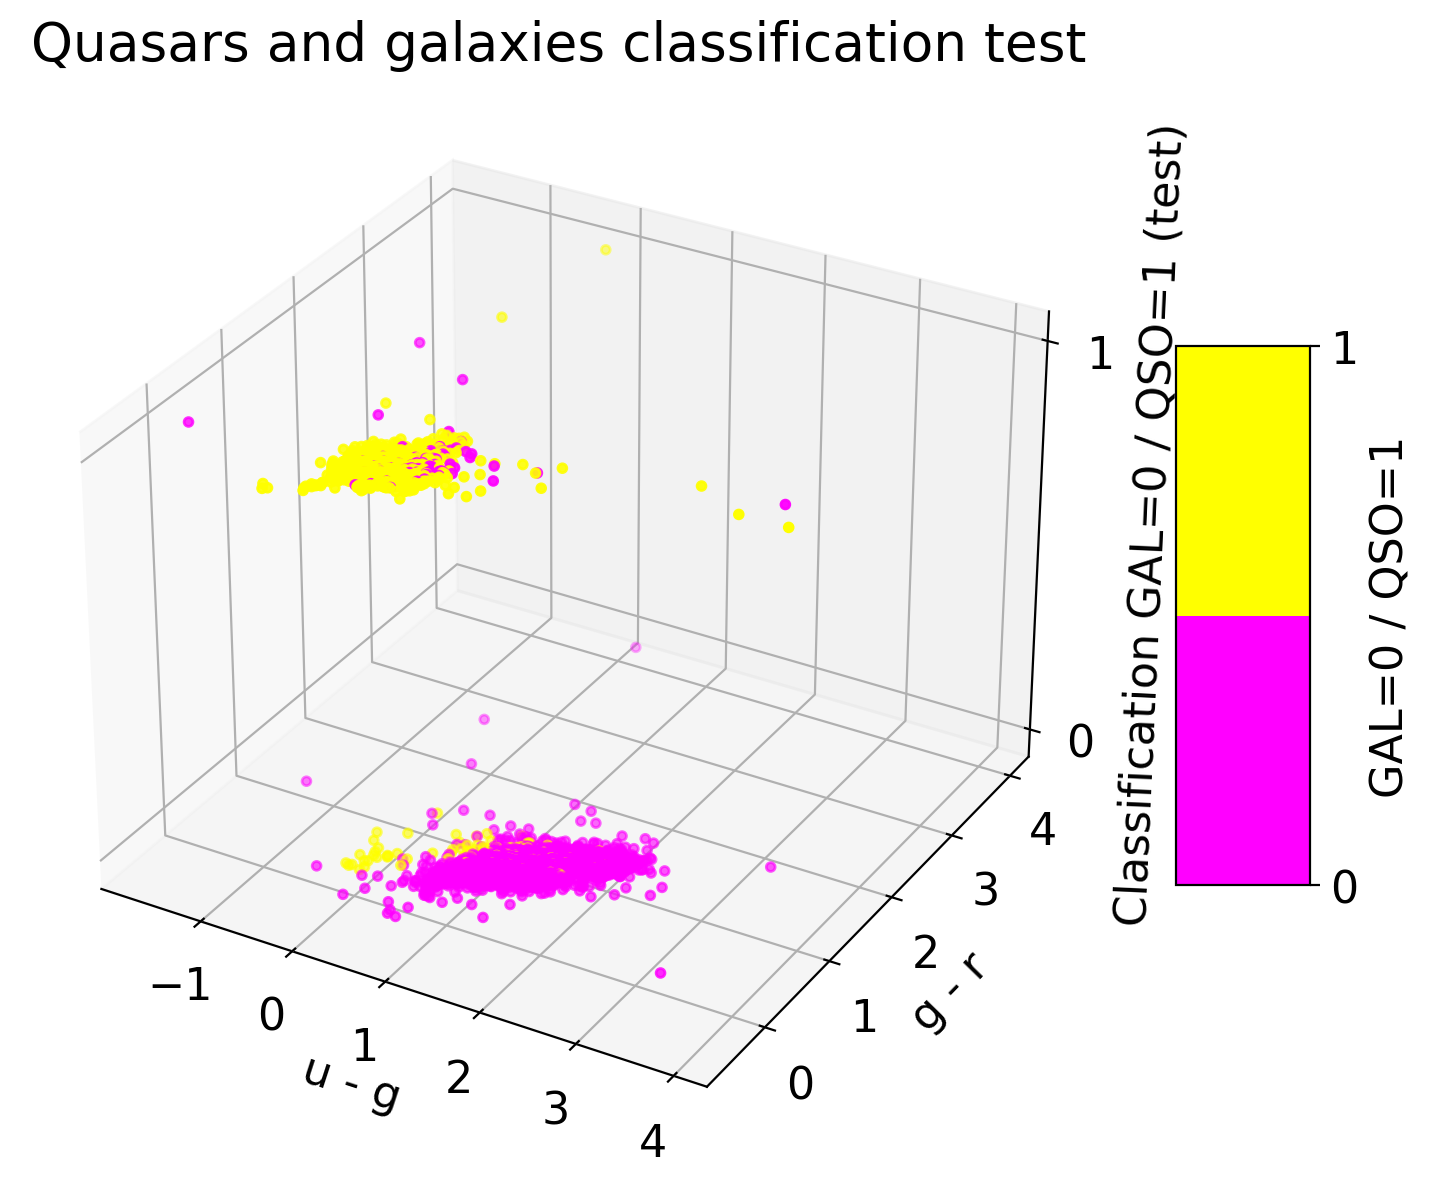

In [13]:
#%matplotlib notebook

# Creating plot
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.set_xlabel("u - g")
ax.set_ylabel("g - r")
ax.set_zlabel("Classification GAL=0 / QSO=1 (train)")
ax.set_zticks(ticks=np.arange(0,10))



sctt2 = ax.scatter3D(X_train[:,0], X_train[:,1], y_pred_train, s=10, c = y_train, cmap=plt.cm.get_cmap('spring', 2))#, edgecolor='gray', zorder=1)
plt.title("Quasars and galaxies classification train")
fig.colorbar(sctt2, ax = ax, shrink = 0.5, aspect = 4, label="GAL=0 / QSO=1", ticks=range(10))
 
# show plot
plt.show()

# Creating plot
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.set_xlabel("u - g")
ax.set_ylabel("g - r")
ax.set_zlabel("Classification GAL=0 / QSO=1 (test)")
ax.set_zticks(ticks=np.arange(0,2))



sctt2 = ax.scatter3D(X_test[:,0], X_test[:,1], y_pred_test, s=10, c = y_test, cmap=plt.cm.get_cmap('spring', 2))#, edgecolor='gray', zorder=1)
plt.title("Quasars and galaxies classification test")
fig.colorbar(sctt2, ax = ax, shrink = 0.5, aspect = 4, label="GAL=0 / QSO=1", ticks=range(2))
 
# show plot
plt.show()

###### Scores

In [14]:
train_score = accuracy_score(y_pred_train, y_train)
test_score = accuracy_score(y_pred_test, y_test)
print("Train score: ", train_score, "\nTest score (significant one): ", test_score)

Train score:  0.9863 
Test score (significant one):  0.9844


###### Let's try the classification with all 5 components (4 colors + redshift) one at a time

In [15]:
ndim = np.arange(1, X_train.shape[1] + 1)
ncomp = 2       # 2 clusters
print(ndim)

predictions = []

for i in ndim:
    gmmb_i = GMMBayes(ncomp) 
    gmmb_i.fit(X_train[:,:i],y_train)

    y_pred_test = gmmb_i.predict(X_test[:,:i])
    predictions.append(y_pred_test)
    
completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

"""
# Compute the decision boundary
gmmb_i
xlim = (-3, 6)
ylim = (-11, 5)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),np.linspace(ylim[0], ylim[1], 81))
print(xx.shape)
#Zx = gmmb_i.predict_proba(np.arange())
#Zy = gmmb_i.predict_proba(yy)
#print(Zx.shape, "\n", Zx)
#Z = Z[:, 1].reshape(xx.shape)
"""

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f941d0f2a60>
Traceback (most recent call last):
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


[1 2 3 4 5]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f941d0f2f70>
Traceback (most recent call last):
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

completeness [0.90056022 0.94047619 0.92296919 0.93137255 0.93767507]
contamination [0.05092251 0.07506887 0.07183099 0.16666667 0.04765292]


'\n# Compute the decision boundary\ngmmb_i\nxlim = (-3, 6)\nylim = (-11, 5)\n\nxx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),np.linspace(ylim[0], ylim[1], 81))\nprint(xx.shape)\n#Zx = gmmb_i.predict_proba(np.arange())\n#Zy = gmmb_i.predict_proba(yy)\n#print(Zx.shape, "\n", Zx)\n#Z = Z[:, 1].reshape(xx.shape)\n'

/tmp/ipykernel_8999/766531903.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.scatter(X_train[:,0], X_train[:,1], y_pred_train, s=10, c=y_train, cmap=plt.cm.get_cmap('spring', 2), zorder=2)


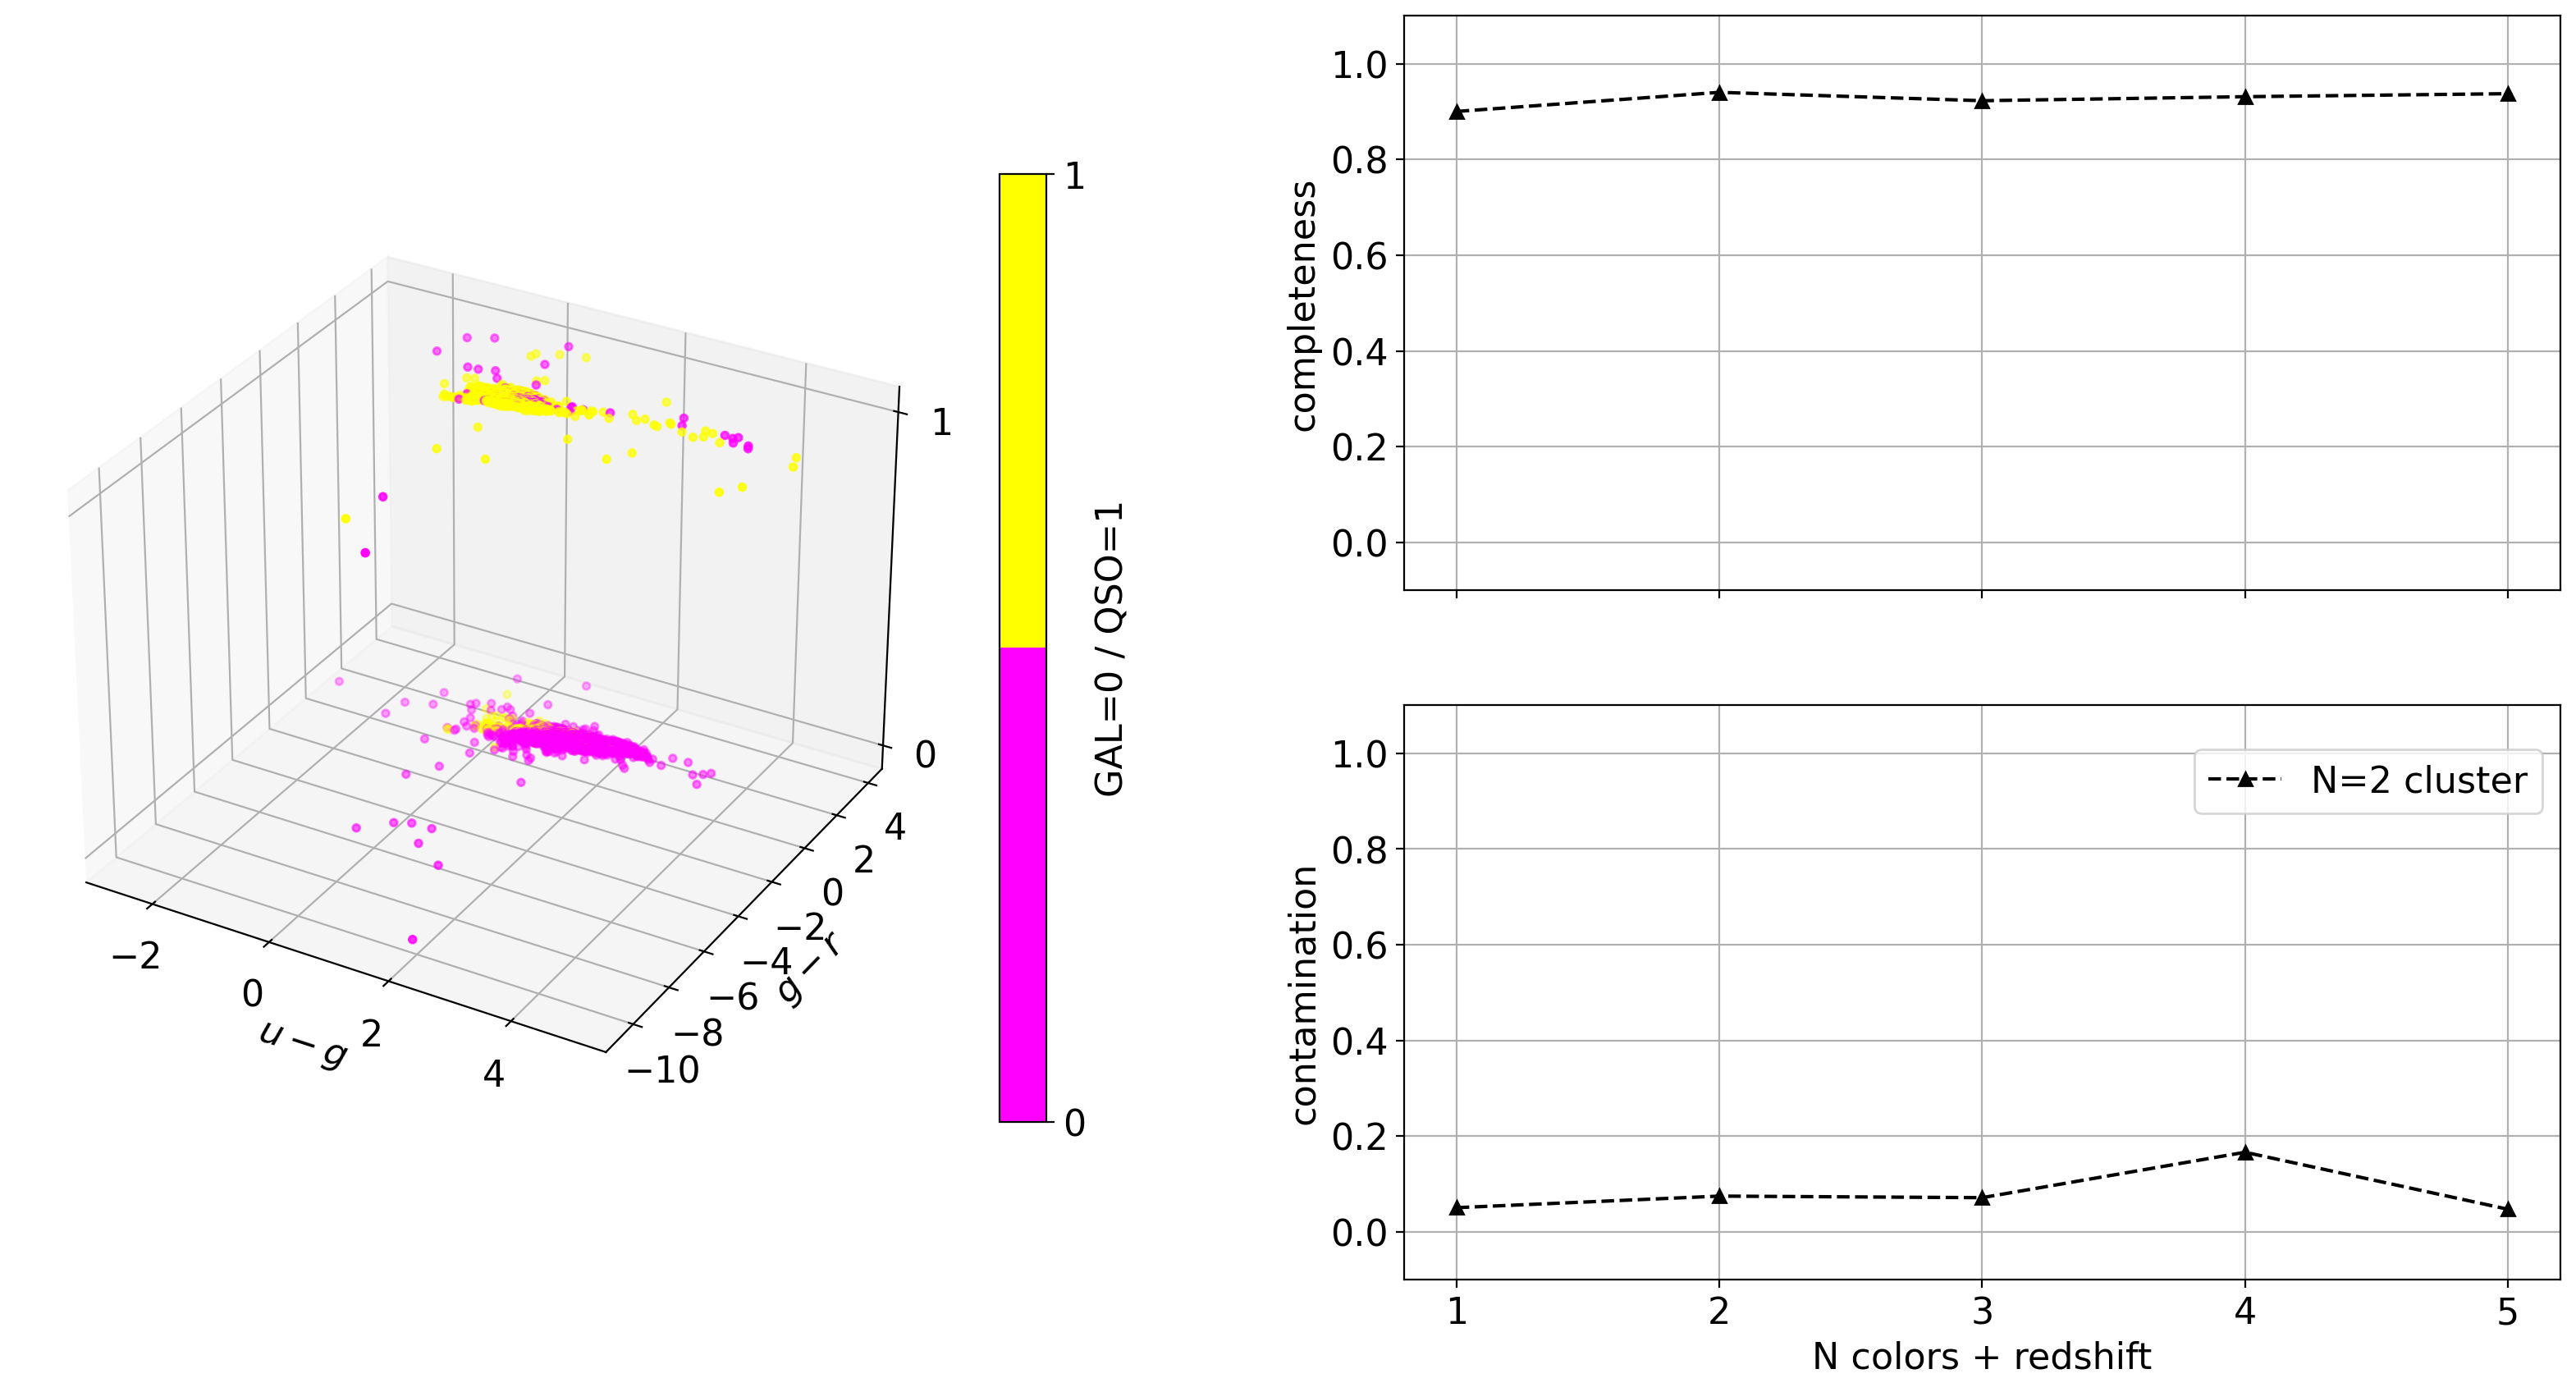

In [16]:
%matplotlib inline
# plot the results
fig = plt.figure(figsize=(20, 10))
#fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,left=0.1, right=0.95, wspace=0.2)
gs = fig.add_gridspec(2, 2,  width_ratios=(5, 1), height_ratios=(3, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)


# left plot: data and decision boundary
ax = fig.add_subplot(121, projection='3d')
im = ax.scatter(X_train[:,0], X_train[:,1], y_pred_train, s=10, c=y_train, cmap=plt.cm.get_cmap('spring', 2), zorder=2)
ax.set_zticks(ticks=range(2))
plt.colorbar(im, shrink = 0.75, label="GAL=0 / QSO=1", ticks=[0,1])


#im.colorbar()
#im.set_clim(-0.5, 1)

#im = ax.imshow(Z, origin='lower', aspect='auto',cmap=plt.cm.binary, zorder=1,extent=xlim + ylim)
#im.set_clim(0, 1.5)

#ax.contour(xx, yy, Z, [0.1], colors='k')

#ax.set_xlim(xlim)
#ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# right plot: completeness vs ndim (4 col + redshift)
ax = fig.add_subplot(222)
ax.plot(ndim, completeness, '^--k', ms=6, label='N=%i' % ncomp)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
#ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(ndim, contamination, '^--k', ms=6, label='N=%i cluster' % ncomp)
ax.legend(loc='lower right',bbox_to_anchor=(1.0, 0.78))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors + redshift')
ax.set_ylabel('contamination')
#ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

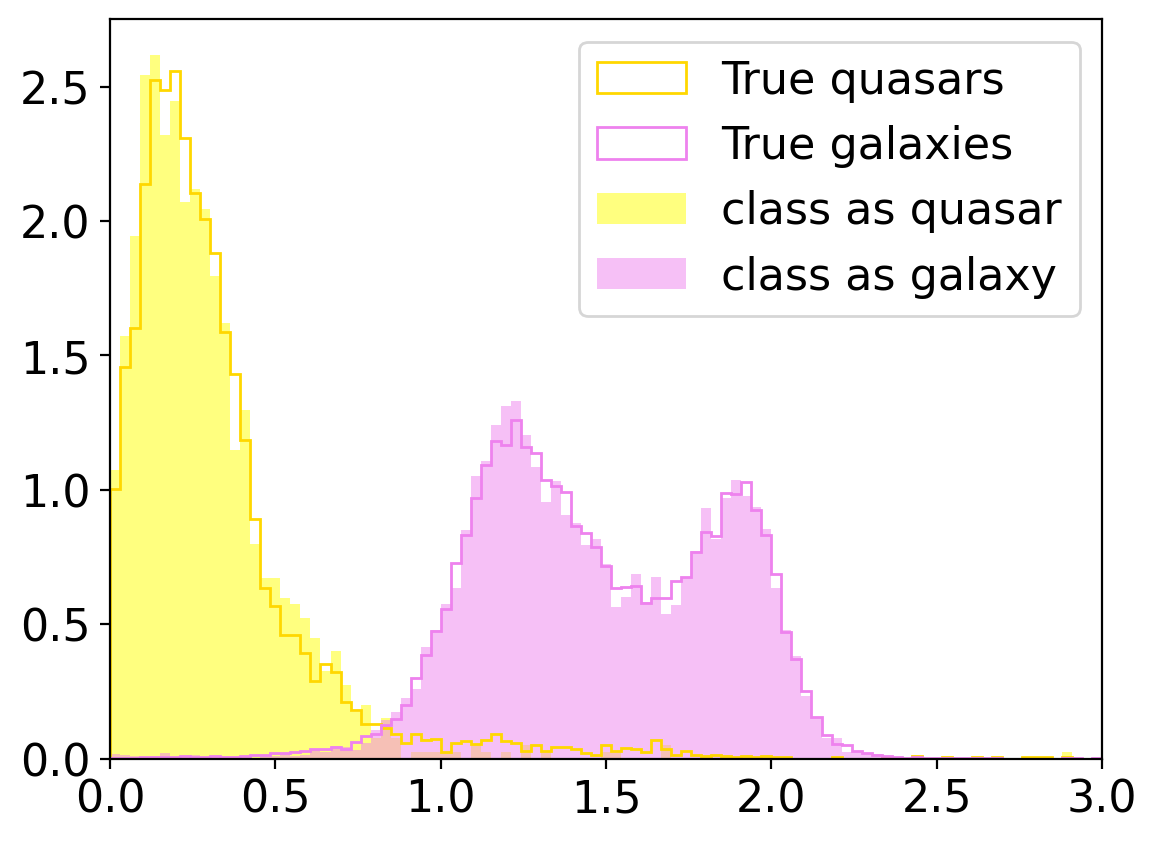

In [17]:
plt.hist(u_g[target == 1], histtype='step',bins=np.linspace(0,3,100),density=True, 
         color='gold', label='True quasars')
plt.hist(u_g[target == 0], histtype='step',bins=np.linspace(0,3,100),density=True, 
         color='violet', label='True galaxies')

plt.hist(X_test[:,0][predictions[4]==1],histtype='stepfilled',bins=np.linspace(0,3,100),density=True, 
         color='yellow',alpha=0.5,label='class as quasar')
plt.hist(X_test[:,0][predictions[4]==0],histtype='stepfilled',bins=np.linspace(0,3,100),density=True, 
         color='violet',alpha=0.5,label='class as galaxy')
plt.xlim(0,3)
plt.legend()
plt.show()